### Canny + Hog + Hu Moments + haralick + ResNet + Pixels

In [4]:
import csv
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import skimage
from skimage.io import ImageCollection,concatenate_images,imread
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
#from keras.applications.xception import Xception
from keras.applications import resnet50
from keras.applications import xception
from keras.applications import vgg16
from sklearn.ensemble import VotingClassifier

#import mahotas as mt
#import xgboost as xg



In [5]:

def returnImagesAndLabels(path):
  
    lab = pd.read_csv('dataset/train.csv')
    images = []
    files = []
    labels = []
    for index, row in lab.iterrows():
        files.append(row['Id'])
        labels.append(row['Category'])
    target = []
    #img_c = cv2.imread(path+ '/'+ files[i])
    #img_c = cv2.cvtColor(img_c,cv2.COLOR_BGR2HSV)
    
    #cv2.normalize(histr,histr)
    #fd = histr.flatten()
    #hist.append(fd)
    for i in range(len(files)):
        name = path+'/'+files[i]
        overallPath = path+'train/'+files[i]
        img = cv2.imread(path+ 'train/'+ files[i],0)
        #histr = cv2.calcHist([img],[0,1,2],None,[8,8,8],[0,256,0,256,0,256]) 
        images.append(img)
        
        target.append(labels[i])
        
    return images,target
        
        


In [6]:
#extracting images and their target/labels
images, target = returnImagesAndLabels('dataset/')

#converting them to numpy arrays
images = np.array(images)
target = np.array(target)


In [7]:


#utility functions for pickling 
# dumping into pickle
def pickleDump(dataToBeDumoped,name):
    import pickle 
    dbfile = open(name, 'ab') 
    pickle.dump(dataToBeDumoped,dbfile)
    dbfile.close()

    
#loadingPickle
def loadPickleData(nameOfPickleFile):
    import pickle 
    dbfile = open(nameOfPickleFile, 'rb')      
    loaded = pickle.load(dbfile)
    
    return loaded

In [8]:
#give me images array to extract hog features from them
def hogFeatures(pixels):
    from skimage.feature import hog
    hogs = []
    for i in range(len(pixels)):
        if(pixels[i].shape == 3):
            fd = hog(pixels[i], orientations=16, pixels_per_cell=(16, 16),cells_per_block=(2, 2),multichannel=True)
            hogs.append(fd)
        else:
            fd = hog(pixels[i], orientations=16, pixels_per_cell=(16, 16),cells_per_block=(2, 2))
            hogs.append(fd)
    return hogs


In [9]:
#pass images as arguements
hog = hogFeatures(images)
hog = np.array(hog)
print(hog.shape)

(10000, 576)


In [10]:



# To plot 
def eigen_energy_plot(data):
    pca = PCA()
    pca.fit(data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)*100
    d = [n for n in range(len(cumsum))]
    plt.figure(figsize=(10, 10))
    plt.plot(d,cumsum, color = 'green',label='EigenEnergy')
    plt.title('number of principal components vs eigen energy:  HOG Features')
    plt.ylabel('Eigen Energy')
    plt.xlabel('ALL Principal components')
    plt.axhline(y = 95, color='k', linestyle='--', label = '95% Eigen Energy')
    plt.legend(loc='best')
    


    

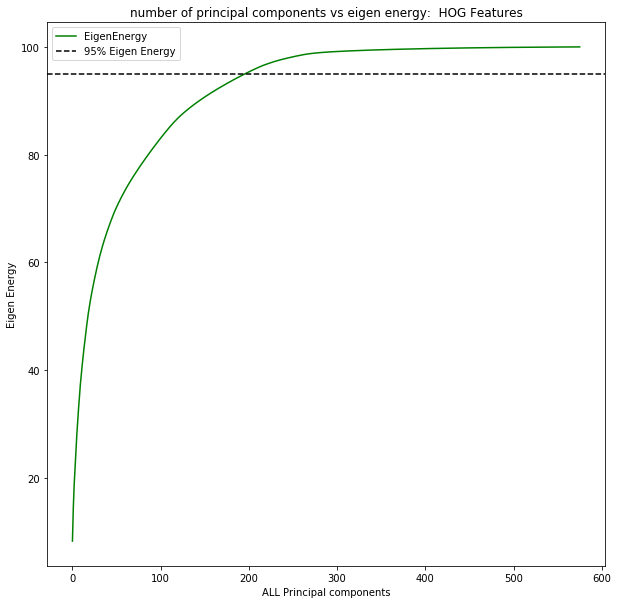

In [11]:
eigen_energy_plot(hog)

In [12]:
def extractHaralickPickle(path):
    return loadPickleData(path+'haralick')
haralick = extractHaralickPickle('')

hog_haralick = np.concatenate((hog,haralick),axis=1)
def getHuMoments(path):
    return loadPickleData(path+'humom')

humom = getHuMoments('')

hog_humom_haralick = np.concatenate((humom,hog,haralick),axis=1)

In [13]:
from keras import applications
model = applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [14]:
#model.summary()

In [15]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
path = 'dataset/train/train_8084.jpg'


In [13]:
def returnKerasImages(path):
    lab = pd.read_csv('dataset/train.csv')
    images = []
    files = []
    labels = []
    for index, row in lab.iterrows():
        files.append(row['Id'])
        labels.append(row['Category'])
#        print()
    print(files[0])
    target = []
    for i in range(len(files)):
#        print(i)
        name = path+'/'+files[i]
        overallPath = path+'train/'+files[i]
 
        img = image.load_img(overallPath, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)

        images.append(x)
        
        target.append(labels[i])
        
    return images,target
        
        



In [14]:
keras_images, target = returnKerasImages('dataset/')

train_0.jpg


In [15]:
#input a small number of n here to test the methodology because n = 10,000 will take forever on CPU. 
# n = 500, gives 65% accuracy. increasing n increases the accuracy
# here n is the number of samples. 
n = 500
def resnet_features(keras_images):
    res_features = []
    for i in range((n)):
        res_features.append(model.predict(keras_images[i]))
    return res_features
        
    

In [16]:
res_feats = resnet_features(keras_images)


res_feats = np.array(res_feats).reshape(n,1000)

X_train, X_test, y_train, y_test = train_test_split(res_feats, target[0:n], test_size=0.20, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=20, random_state=42)

from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(n_estimators=250,max_features='sqrt',n_jobs=-1,random_state=10)

rf.fit(X_train, y_train)
print("Train accuracy: ", rf.score(X_train,y_train))
print("Test accuracy: ", rf.score(X_test,y_test))






Train accuracy:  1.0
Test accuracy:  0.59


In [17]:
from skimage import feature
def getCannyEdges(images):
    cannies = []
    for i in range(len(images)):
        cannies.append(feature.canny(images[i]).flatten())
    return cannies
cannies = getCannyEdges(images)

cannies = np.array(cannies)

In [18]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def getFlattenedPixelVector(images):
    pixels = []
    for i in range(len(images)):
        if((len(images[i].shape)) == 3):
            pixels.append(rgb2gray(images[i]).flatten())
        else: 
            pixels.append(images[i].flatten())
    return pixels
    

In [19]:
pixels = getFlattenedPixelVector(images)
pixels = np.array(pixels)
#print(pixels.shape)

In [20]:
temp = np.concatenate((hog_humom_haralick[0:500],res_feats,cannies[0:500],pixels[0:500]),axis=1)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(temp, target[0:500], test_size=20, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=20, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(n_estimators=500,max_features='sqrt',n_jobs=-1,random_state=10)

rf.fit(X_train, y_train)
print("Train accuracy: ", rf.score(X_train,y_train))
print("Test accuracy: ", rf.score(X_test,y_test))








Train accuracy:  1.0
Test accuracy:  0.65


In [23]:
temp.shape

(500, 9788)